In [1]:
# Install required libraries for web scraping and data handling.
# Uncomment and run this line if the necessary packages are not already installed.
# - selenium: for browser automation
# - pandas: for data manipulation and analysis
# - webdriver-manager: to automatically manage browser drivers
# !pip install selenium pandas webdriver-manager

In [2]:
# Standard libraries
import time                            # For managing delays and waits
import random                          # For introducing randomised behaviour (e.g. delays)
import re                              # For working with regular expressions
import sys                             # For interacting with the system (e.g. for exiting)

# Data handling and analysis
import pandas as pd                    # Data manipulation and analysis

# Selenium libraries for browser automation
from selenium import webdriver
from selenium.webdriver.common.by import By                               # For locating elements
from selenium.webdriver.chrome.options import Options                     # To configure Chrome options
from selenium.webdriver.chrome.service import Service                     # For setting up Chrome driver service
from selenium.webdriver.support.ui import WebDriverWait                   # Explicit waits
from selenium.webdriver.support import expected_conditions as EC          # Conditions for waits
from selenium.common.exceptions import NoSuchElementException             # Exception handling

# Automatically download and manage ChromeDriver
from webdriver_manager.chrome import ChromeDriverManager

# URL parsing utilities
from urllib.parse import urlparse, urlunparse                              # For manipulating URLs

# Utility for counting element frequencies
from collections import Counter                                            # Count elements (e.g. skills, words)

# Plotting
import matplotlib.pyplot as plt                                            # Visualisation library

In [3]:
# Clean a URL by removing parameters, queries, and fragments
def clean_url(url):
    parsed = urlparse(url)  # Parse the URL into components
    return urlunparse((parsed.scheme, parsed.netloc, parsed.path, '', '', ''))  # Keep only base parts

# Extract years of experience from a string (e.g. "2+ years", "3 to 5 years")
def extract_experience(text):
    match = re.search(r'(\d+)[\+ ]*(?:\s*to\s*(\d+))?\s+years?', str(text), re.IGNORECASE)
    if match:
        if match.group(2):  # If a range is matched (e.g. "3 to 5 years")
            return f"{match.group(1)}-{match.group(2)}"
        else:  # If a single number is matched (e.g. "2+ years")
            return match.group(1)
    return None  # Return None if no match found

# Split a location string into city and state (assuming last word is the state)
def split_location(loc):
    parts = str(loc).split()
    if len(parts) >= 2:
        state = parts[-1]  # Last word assumed to be the state
        city = " ".join(parts[:-1])  # All words before that make up the city
    else:
        city, state = loc, ""  # If there's only one part, treat it as city
    return city, state

# Predefined list of keywords (languages, frameworks, tools, etc.) to detect in job descriptions
keyword_list = [
    # Languages
    "Python", "SQL", "Java", "JavaScript", "C++", "C#", "C Programming", "R Programming", "Scala", "Go", "Ruby", "PHP",
    "Shell", "PowerShell", "Bash", "TypeScript", "HTML", "CSS", "T-SQL", "VBA", "MATLAB",
    
    # Frameworks
    "Node.js", "React", "Angular", "Vue.js", "Express", "Next.js", "Flask", "Django", "ASP.NET", "Spring", "jQuery",
    "Laravel", "Symfony", "Ruby on Rails", "FastAPI", "Phoenix",
    
    # Cloud
    "AWS", "Azure", "GCP", "IBM Cloud", "Oracle", "Firebase", "Redshift", "Snowflake", "DataBricks", "BigQuery",
    "Digital Ocean", "OpenStack", "Colocation", "Watson", "VMware", "Heroku",
    
    # Databases
    "SQL Server", "MySQL", "PostgreSQL", "Cassandra", "MongoDB", "ElasticSearch", "DynamoDB", "Redis", "DB2",
    "Neo4j", "MariaDB", "CouchDB", "Couchbase", "SQLite", "Firestore",
    
    # Tools
    "Power BI", "Tableau", "Looker", "Excel", "Word", "SAP", "SAS", "SPSS", "Qlik", "SSIS", "SSRS", "Alteryx",
    "MicroStrategy", "Google Sheets", "Spreadsheets", "DAX", "Outlook", "Visio", "MS Access", "DataRobot", "Splunk",
    "Jira", "Confluence",
    
    # Systems and Services
    "Linux", "Linux Shell", "Zsh", "Windows Server", "Active Directory", "Group Policy", "Networking", "Switching",
    "Routing", "Firewalls", "VPN", "Remote Desktop",
    
    # Libraries
    "TensorFlow", "PyTorch", "NumPy", "Pandas", "Scikit-learn", "Keras", "Jupyter", "Matplotlib", "Seaborn", "NLTK",
    "OpenCV", "GraphQL",
    
    # Platforms and Concepts
    "Airflow", "Spark", "Kafka", "Hadoop", "Hive", "ETL", "DevOps", "CI/CD", "Git", "GitHub", "Bitbucket",
    "Terraform", "Ansible", "Jenkins", "Bamboo", "Nagios", "Prometheus", "Grafana", "New Relic", "Datadog",
    "Logstash", "Snort", "Wireshark",
    
    # Security & Integration
    "OAuth", "SSO", "SAML", "LDAP",
    
    # Roles & Concepts
    "IT Support", "Service Desk", "Help Desk", "Desktop Support", "Machine Learning", "Deep Learning", "NLP",
    "Microservices", "RESTful Services", "SOAP", "Rest API",
    
    # CRMs and CMS
    "Salesforce", "Zoho", "HubSpot", "Dynamics 365", "Shopify", "WordPress", "WooCommerce", "Magento", "Bootstrap",
    "Tailwind", "Webpack",
    
    # Agile Practices
    "Agile", "Scrum", "Kanban", "ITIL"
]

# Extract relevant skills from a text by matching them against the keyword list
def extract_skills(text):
    return ", ".join(
        sorted(
            set([
                skill for skill in keyword_list
                if skill.lower() in str(text).lower()
            ])
        )
    )

In [4]:
# Configure Chrome browser options for headless scraping
options = Options()
options.add_argument("--headless")                 # Run Chrome in headless mode (no GUI)
options.add_argument("--no-sandbox")               # Disable the sandbox (needed in some environments like Docker)
options.add_argument("--disable-dev-shm-usage")    # Overcome limited resource issues in shared memory

# Set up ChromeDriver service using webdriver-manager for automatic installation
service = Service(ChromeDriverManager().install())

# Launch the Chrome browser with the specified options and service
driver = webdriver.Chrome(service=service, options=options)

# Define an explicit wait to allow elements to load before interacting
wait = WebDriverWait(driver, 3.6)  # 3.6 seconds wait time

In [5]:
# Define a comprehensive list of search terms related to entry-level and specialised IT roles
search_terms = [
    "Entry level IT", "Software Developer", "Software Engineer", "Machine Learning Engineer", "IT Consultant",
    "IT support", "Data Entry", "Computing", "ICT jobs", "IT internship", "Data Analyst", "Data Scientist",
    "Business Analyst", "Full Stack Developer", "AI Engineer", "Entry level tech", "Tech graduate program",
    "Front End Developer", "IT", "Back End Developer", "Cyber Security Analyst", "Cyber Security Architect",
    "Cloud Engineer", "Cloud Architect", "DevOps Engineer", "Machine Learning Engineer", "AI Engineer",
    "IT Support Specialist", "Help Desk Technician", "Network Engineer", "Systems Administrator",
    "IT Project Manager", "Technical Project Manager", "Solutions Architect", "Enterprise Architect",
    "Database Administrator"
]

# Initialise an empty list to store job data
job_data = []

# Keep track of URLs that have already been visited to avoid duplicates
visited_urls = set()

# Set the maximum number of jobs to collect
max_jobs = 9000

In [6]:
# Loop through each search term in the predefined list
for term in search_terms:
    if len(job_data) >= max_jobs:
        break  # Stop if max job count is reached

    print(f"\n🔍 Query: {term}")
    driver.get(f"https://au.jora.com/j?sp=search&q={term}&psf=new")  # Navigate to search results page
    time.sleep(3)  # Wait for page to load
    page_num = 1

    # Loop through pages of results until job limit is hit
    while len(job_data) < max_jobs:
        # Close any popup if it appears
        try:
            popup = driver.find_element(By.CSS_SELECTOR, 'div[data-automation="modal"]')
            close_btn = popup.find_element(By.CSS_SELECTOR, 'button')
            close_btn.click()
            time.sleep(1)
        except:
            pass  # If popup does not appear, continue silently

        # Wait for job cards to load and retrieve them
        try:
            wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.job-card.result.organic-job")))
            job_cards = driver.find_elements(By.CSS_SELECTOR, "div.job-card.result.organic-job")
        except:
            break  # If job cards cannot be found, stop paging

        # Loop through each job card on the current page
        for card in job_cards:
            if len(job_data) >= max_jobs:
                break  # Stop if enough jobs collected

            try:
                # Extract job metadata elements
                title_el = card.find_element(By.CSS_SELECTOR, "h2.job-title a.job-link")
                company_el = card.find_element(By.CSS_SELECTOR, "div.job-info span.job-company")
                location_el = card.find_element(By.CSS_SELECTOR, "div.job-info a.job-location")
                summary_el = card.find_element(By.CSS_SELECTOR, "div.job-abstract")

                # Clean and assign values
                title = title_el.text.strip()
                company = company_el.text.strip()
                location = location_el.text.strip()
                summary = summary_el.text.strip()
                job_url = clean_url(title_el.get_attribute("href"))

                # Skip duplicates
                if job_url in visited_urls:
                    continue
                visited_urls.add(job_url)

                # Parse city/state and extract features
                city, state = split_location(location)
                skills = extract_skills(summary)
                experience = extract_experience(summary)

                # Append job data to list
                job_data.append({
                    "Title": title,
                    "Company": company,
                    "City": city,
                    "State": state,
                    "Description": summary,
                    "Skills": skills,
                    "Experience": experience,
                    "Job URL": job_url
                })

                # Display scraping progress
                percent = round(len(job_data) / max_jobs * 100, 2)
                sys.stdout.write(f"\r📊 Scraping progress: {percent}%")
                sys.stdout.flush()

            except:
                continue  # Skip job card if any issue occurs

        # Attempt to go to the next page of results
        try:
            next_btn = driver.find_element(By.CSS_SELECTOR, "a.next-page-button")
            driver.execute_script("arguments[0].click();", next_btn)
            time.sleep(random.uniform(2.0, 3.5))  # Add random delay to reduce detection
            page_num += 1
        except NoSuchElementException:
            break  # Stop if no "next" button found

# Close the browser session once all scraping is complete
driver.quit()

# Print completion message
print("\n✅ Scraping completed.")


🔍 Query: Entry level IT
📊 Scraping progress: 5.57%
🔍 Query: Software Developer
📊 Scraping progress: 9.56%
🔍 Query: Software Engineer
📊 Scraping progress: 12.52%
🔍 Query: Machine Learning Engineer
📊 Scraping progress: 17.67%
🔍 Query: IT Consultant
📊 Scraping progress: 21.34%
🔍 Query: IT support
📊 Scraping progress: 23.24%
🔍 Query: Data Entry
📊 Scraping progress: 27.22%
🔍 Query: Computing
📊 Scraping progress: 31.56%
🔍 Query: ICT jobs
📊 Scraping progress: 34.38%
🔍 Query: IT internship
📊 Scraping progress: 39.46%
🔍 Query: Data Analyst
📊 Scraping progress: 43.31%
🔍 Query: Data Scientist
📊 Scraping progress: 45.31%
🔍 Query: Business Analyst
📊 Scraping progress: 49.04%
🔍 Query: Full Stack Developer
📊 Scraping progress: 53.2%%
🔍 Query: AI Engineer
📊 Scraping progress: 55.14%
🔍 Query: Entry level tech
📊 Scraping progress: 56.6%%
🔍 Query: Tech graduate program
📊 Scraping progress: 58.63%
🔍 Query: Front End Developer
📊 Scraping progress: 61.58%
🔍 Query: IT
📊 Scraping progress: 63.34%
🔍 Query: Ba

In [21]:
# Create a DataFrame from the collected job data and order the columns for clarity
df_final = pd.DataFrame(job_data)[[
    "Title",
    "Company",
    "City",
    "State",
    "Description",
    "Skills",
    "Experience",
    "Job URL"
]]

# Save the DataFrame to a CSV file without the index and using UTF-8 encoding
df_final.to_csv("enriched_jora_jobs_9000.csv", index=False, encoding="utf-8")

# Print confirmation and preview of saved data
print(f"📁 Saved {len(df_final)} jobs to jora_jobs_9000.csv")

📁 Saved 9000 jobs to jora_jobs_9000.csv


In [20]:
print(df_final.head())

                                               Title                 Company  \
0  IT Support Officer (Level 1/ Graduate/ Entry L...     Acworth Recruitment   
1                                  Help Desk Support               BGP Group   
2                                Junior System Admin        Hays Recruitment   
3                             IT Helpdesk Technician            Sol1 Pty Ltd   
4                                   IT Support Agent  CSP Lighthouse Pty Ltd   

           City State                                        Description  \
0     Inglewood    WA  Recent IT graduate with strong customer servic...   
1        Sydney   NSW  More than 4 years of relevant work experience ...   
2    Sydney CBD   NSW  Assist in IT system installation, maintenance,...   
3   Bella Vista   NSW  Provide IT support for SME customers at Bella ...   
4  Bedford Park    SA  Requires Australian Citizenship and Baseline S...   

                                    Skills Experience  \
0    

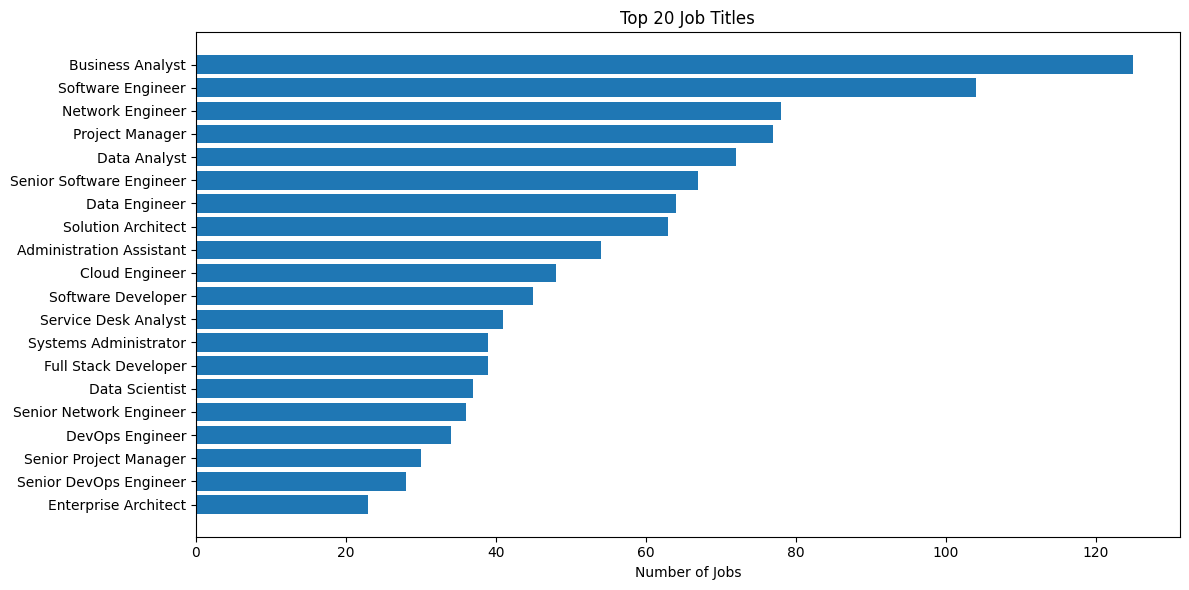

In [19]:
# Identify the top 20 most frequent job titles in the dataset
top_titles = df_final["Title"].dropna().value_counts().head(20)

# Create a horizontal bar chart to visualise top job titles
plt.figure(figsize=(12, 6))  # Set the figure size
plt.barh(top_titles.index[::-1], top_titles.values[::-1])  # Reverse order for highest at top
plt.xlabel("Number of Jobs")  # Label for x-axis
plt.title("Top 20 Job Titles")  # Plot title
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()  # Display the plot

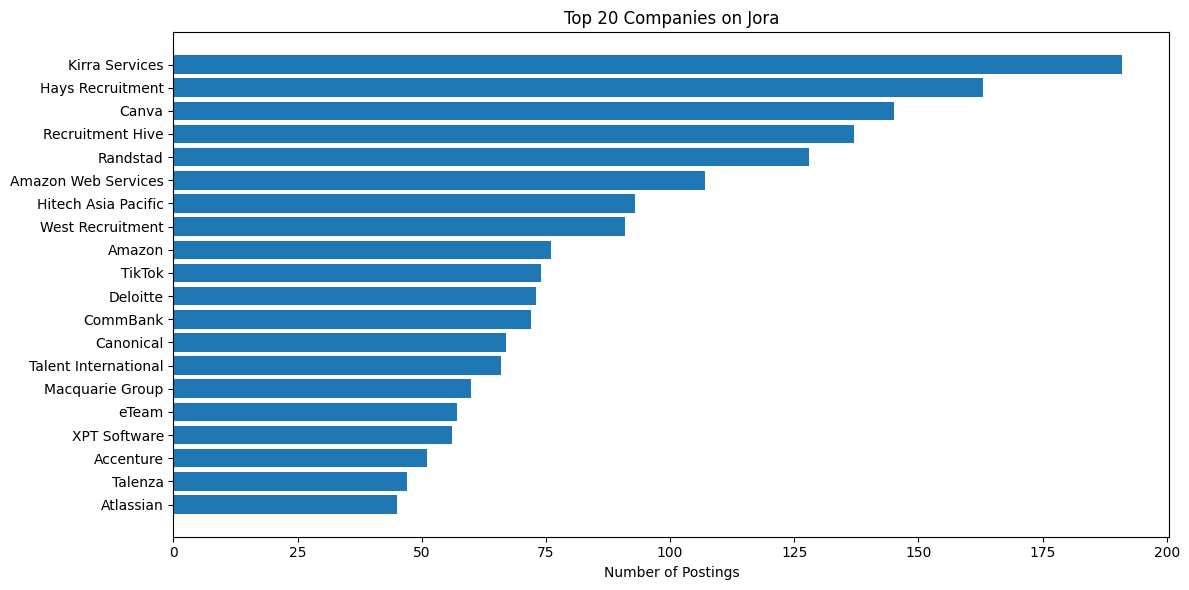

In [18]:
# Identify the top 20 companies with the most job listings
top_companies = df_final["Company"].dropna().value_counts().head(20)

# Create a horizontal bar chart to visualise top hiring companies
plt.figure(figsize=(12, 6))  # Set the figure size
plt.barh(top_companies.index[::-1], top_companies.values[::-1])  # Reverse for descending order
plt.xlabel("Number of Postings")  # X-axis label
plt.title("Top 20 Companies on Jora")  # Plot title
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()  # Display the plot

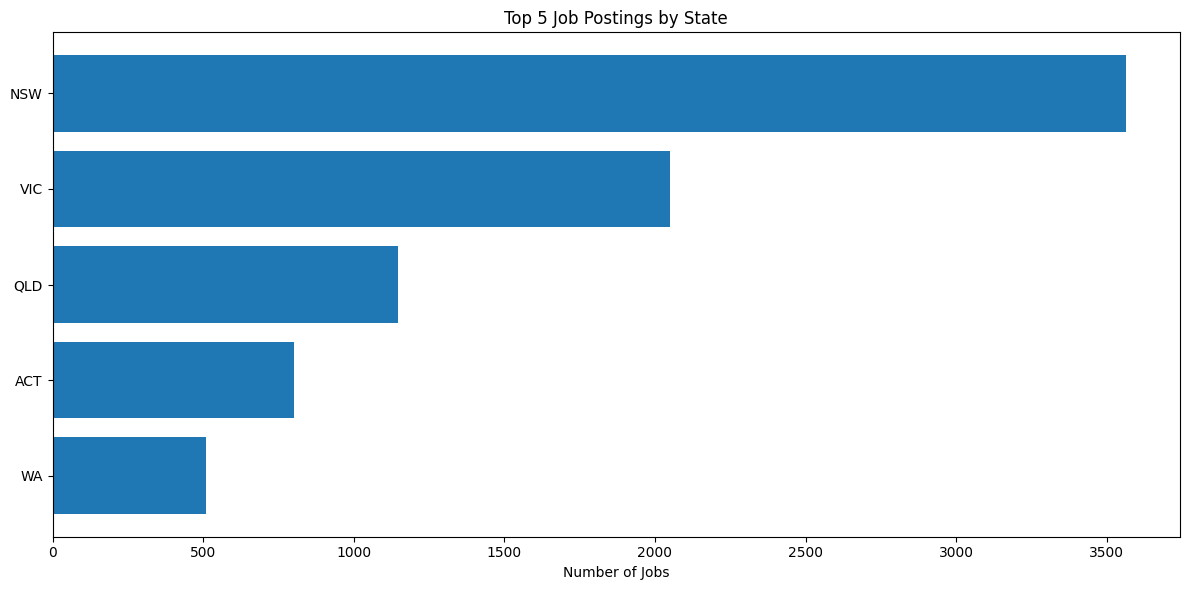

In [17]:
# Get the top 5 states with the highest number of job postings
top_states = df_final["State"].dropna().value_counts().head(5)

# Create a horizontal bar chart to show job distribution by state
plt.figure(figsize=(12, 6))  # Set the figure size
plt.barh(top_states.index[::-1], top_states.values[::-1])  # Reverse for top-down ordering
plt.xlabel("Number of Jobs")  # Label for x-axis
plt.title("Top 5 Job Postings by State")  # Title of the plot
plt.tight_layout()  # Ensure layout fits well
plt.show()  # Render the plot

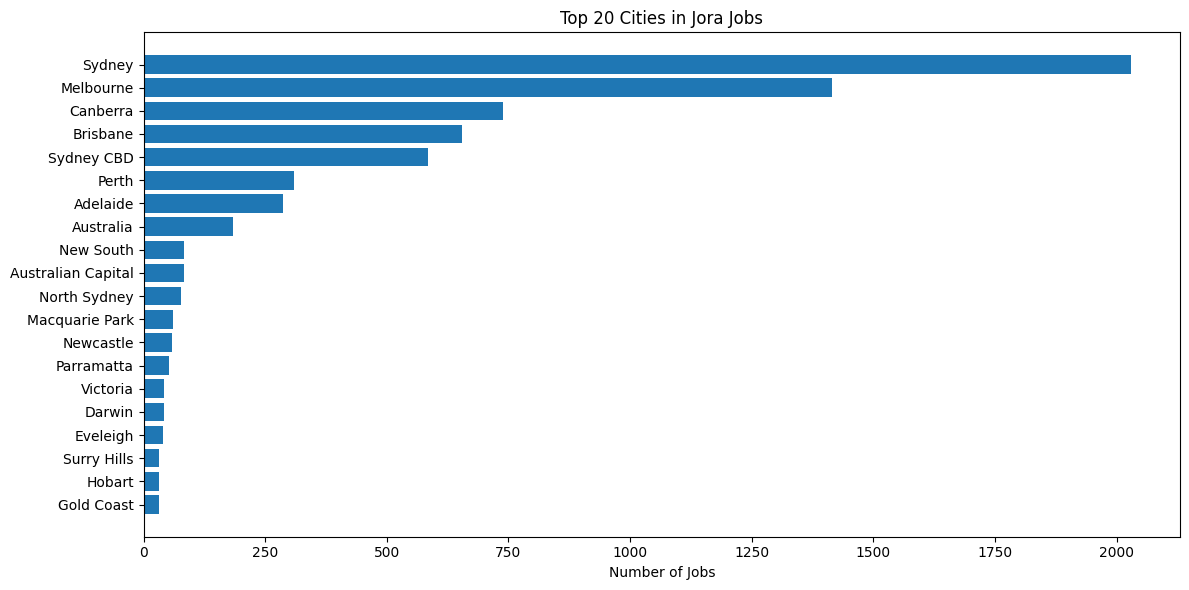

In [14]:
# Identify the top 20 cities with the most job postings
top_cities = df_final["City"].dropna().value_counts().head(20)

# Create a horizontal bar chart to visualise job distribution by city
plt.figure(figsize=(12, 6))  # Define the size of the figure
plt.barh(top_cities.index[::-1], top_cities.values[::-1])  # Plot reversed to show most on top
plt.xlabel("Number of Jobs")  # X-axis label
plt.title("Top 20 Cities in Jora Jobs")  # Title for the plot
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()  # Display the plot

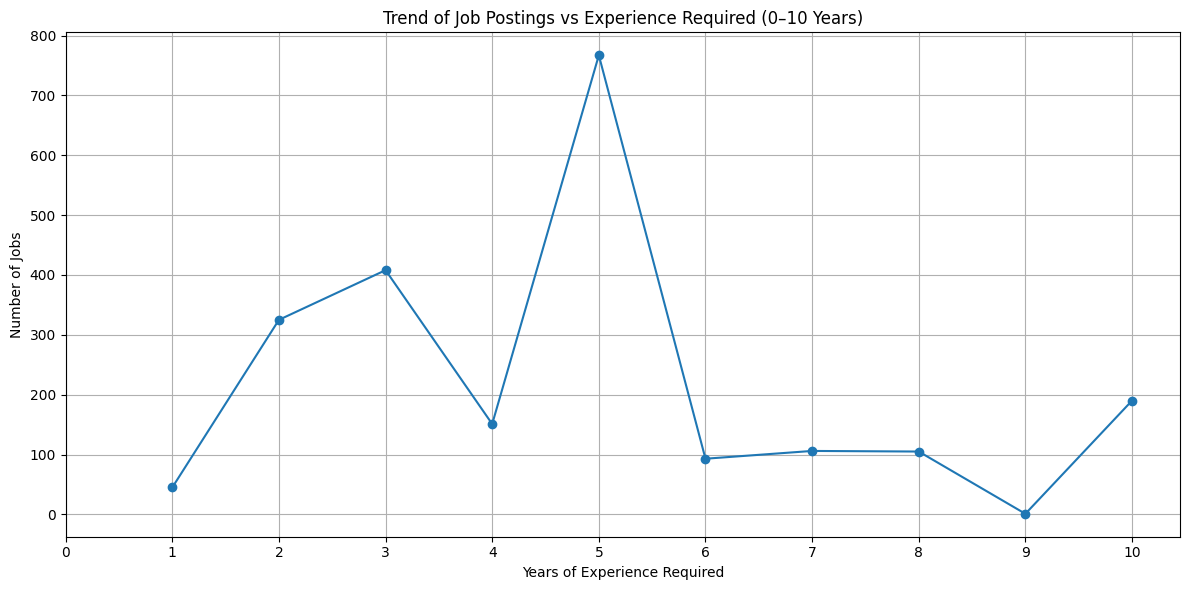

In [16]:
# Convert 'Experience' column to numeric values, coercing invalid entries to NaN and dropping them
experience_levels = pd.to_numeric(df_final["Experience"].dropna(), errors='coerce').dropna()

# Count how many postings correspond to each year of experience
experience_counts = experience_levels.value_counts().sort_index()

# Filter to include only experience values from 0 to 10 years
experience_counts = experience_counts[(experience_counts.index >= 0) & (experience_counts.index <= 10)]

# Create a line plot to show how job postings vary by years of required experience
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(experience_counts.index, experience_counts.values, marker='o')  # Line plot with markers
plt.xlabel("Years of Experience Required")  # X-axis label
plt.ylabel("Number of Jobs")  # Y-axis label
plt.title("Trend of Job Postings vs Experience Required (0–10 Years)")  # Plot title
plt.xticks(range(0, 11))  # Set x-axis ticks from 0 to 10
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Optimise layout
plt.show()  # Display the plot